In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [ ]:
### Read Dataset and Exploratory Data Analysis(EDA)
df = pd.read_csv('weatherAUS.csv')
df.head()
df.info()

# Original dataset Shape
# print("Original dataset shape:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [ ]:
### 01. Data Preprocessing
# 1. Handle missing values

# fix 1 - Fill missing values before mapping
df['RainToday'] = df['RainToday'].fillna('No')
df['RainTomorrow'] = df['RainTomorrow'].fillna('No')

# # 1.1 Drop columns with too many missing values
# drop_cols = ['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']
# for col in drop_cols:
#     if col in df.columns:
#         df.drop(col, axis=1, inplace=True)

# print("Dropped columns:", drop_cols)
# print("Remaining columns:", df.columns.tolist())
# print("-" * 50)

# 1.2 Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()
# Convert numeric columns to numerical values
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Handling numeric missing values
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# Handling categorical missing values
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

# 1.3 Remove duplicates
# df.drop_duplicates(inplace=True)

# 1.3 Remove duplicates
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]

print(f"Duplicates removed: {before - after}")
print(f"Remaining rows: {after}")
print(f"Missing values per column (should be 0):\n{df.isnull().sum()}")
print("-" * 50)

Duplicates removed: 0
Remaining rows: 145460
Missing values per column (should be 0):
Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64
--------------------------------------------------


In [ ]:
# 2. Preprocess Date
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract day, month, year
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Drop the original date column
df.drop('Date', axis=1, inplace=True)

print("Added new date columns (Day, Month, Year):")
print(df[['Day', 'Month', 'Year']].head())
print("Remaining columns:", df.columns.tolist())
print("-" * 50)

Added new date columns (Day, Month, Year):
   Day  Month  Year
0    1     12  2008
1    2     12  2008
2    3     12  2008
3    4     12  2008
4    5     12  2008
Remaining columns: ['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Day', 'Month', 'Year']
--------------------------------------------------


In [ ]:
# Preprocess categorical columns - One hot Encoding

# Encode Target
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

# Encode Others
categorical_cols = df.select_dtypes(include='object').columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# if 'RainTomorrow' in categorical_cols:
#     categorical_cols.remove('RainTomorrow')

print("After one-hot encoding:")
print("New shape:", df.shape)
print("Sample columns:", df.columns[:10].tolist())
print("Remaining columns:", df.columns.tolist())
print("Total number of columns:", len(df.columns))
print("-" * 50)

After one-hot encoding:
New shape: (145460, 117)
Sample columns: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm']
Remaining columns: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Day', 'Month', 'Year', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Locati

In [ ]:
### Handle outliers
# Select numeric columns (excluding target)
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('RainTomorrow')  # do not touch target
numeric_cols.remove('RainToday')     # optional: remove input bool target

# Apply IQR method
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Option 1: Remove rows with outliers
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    # Option 2 (preferred for LSTM): Cap/Clip outliers
    # df[col] = df[col].clip(lower_bound, upper_bound)

print("After handling outliers, dataset shape:", df.shape)

After handling outliers, dataset shape: (29231, 117)


In [ ]:
# Sort dataset chronologically (important for sequences)
df.sort_values(by=['Year','Month','Day'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("Sorted by Date:")
print(df[['Year', 'Month', 'Day']].head(5))
print(df[['Year', 'Month', 'Day']].tail(5))
print("-" * 50)

Sorted by Date:
   Year  Month  Day
0  2008     10   29
1  2008     11    1
2  2008     12    1
3  2008     12    1
4  2008     12    1
       Year  Month  Day
29226  2017      6   25
29227  2017      6   25
29228  2017      6   25
29229  2017      6   25
29230  2017      6   25
--------------------------------------------------


In [ ]:
# Preprocess numeric columns - Scaling
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

if 'RainTomorrow' in numeric_cols:
    numeric_cols.remove('RainTomorrow')
if 'RainToday' in numeric_cols:
    numeric_cols.remove('RainToday')

scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# fix 2 - convert all to bool
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(float)

print("Scaled numeric columns (0–1 range):")
print(df[numeric_cols].describe().T[['min','max']])
print("-" * 50)

Scaled numeric columns (0–1 range):
               min  max
MinTemp        0.0  1.0
MaxTemp        0.0  1.0
Rainfall       0.0  1.0
Evaporation    0.0  1.0
Sunshine       0.0  0.0
WindGustSpeed  0.0  1.0
WindSpeed9am   0.0  1.0
WindSpeed3pm   0.0  1.0
Humidity9am    0.0  1.0
Humidity3pm    0.0  1.0
Pressure9am    0.0  1.0
Pressure3pm    0.0  1.0
Cloud9am       0.0  0.0
Cloud3pm       0.0  0.0
Temp9am        0.0  1.0
Temp3pm        0.0  1.0
Day            0.0  1.0
Month          0.0  1.0
Year           0.0  1.0
--------------------------------------------------


In [ ]:
# Check if all numeric now
print("---->Any object columns left?", df.select_dtypes(include='object').columns.tolist()) #should be false

print("---->Any NaNs left?", df.isnull().any().any())
nan_cols = df.columns[df.isnull().any()].tolist() #should be true

print("Columns with NaNs:", nan_cols)
nan_percent = (df.isnull().sum() / len(df)) * 100
print(nan_percent[nan_percent > 0])

all_numeric = df.dtypes.apply(lambda x: np.issubdtype(x, np.number)).all()
print("---->All columns numeric?", all_numeric)

print("---->Column types:")
for col in df.columns:
    print(f"{col}: {df[col].dtype}")


---->Any object columns left? []
---->Any NaNs left? False
Columns with NaNs: []
Series([], dtype: float64)
---->All columns numeric? True
---->Column types:
MinTemp: float64
MaxTemp: float64
Rainfall: float64
Evaporation: float64
Sunshine: float64
WindGustSpeed: float64
WindSpeed9am: float64
WindSpeed3pm: float64
Humidity9am: float64
Humidity3pm: float64
Pressure9am: float64
Pressure3pm: float64
Cloud9am: float64
Cloud3pm: float64
Temp9am: float64
Temp3pm: float64
RainToday: int64
RainTomorrow: int64
Day: float64
Month: float64
Year: float64
Location_Albany: float64
Location_Albury: float64
Location_AliceSprings: float64
Location_BadgerysCreek: float64
Location_Ballarat: float64
Location_Bendigo: float64
Location_Brisbane: float64
Location_Cairns: float64
Location_Canberra: float64
Location_Cobar: float64
Location_CoffsHarbour: float64
Location_Dartmoor: float64
Location_Darwin: float64
Location_GoldCoast: float64
Location_Hobart: float64
Location_Katherine: float64
Location_Launcesto

## hii

In [ ]:
### Create Seqences

def create_sequences(df, seq_len=7):
    X, y = [], []
    data = df.drop('RainTomorrow', axis=1).values
    target = df['RainTomorrow'].values
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(target[i])
    return np.array(X), np.array(y)

seq_len = 7
X, y = create_sequences(df, seq_len)
print("Sequences created:", X.shape, y.shape)

# After creating sequences
print("X shape (num_sequences, seq_len, num_features):", X.shape)
print("y shape (num_sequences,):", y.shape)

Sequences created: (29224, 7, 116) (29224,)
X shape (num_sequences, seq_len, num_features): (29224, 7, 116)
y shape (num_sequences,): (29224,)


In [ ]:
### Split data to Train/Test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Train shape: (23379, 7, 116) (23379,)
Test shape: (5845, 7, 116) (5845,)
X_train shape: (23379, 7, 116)
y_train shape: (23379,)
X_test shape: (5845, 7, 116)
y_test shape: (5845,)


Balanced training data shapes:
X_train_balanced: (40668, 7, 116)
y_train_balanced: (40668,)


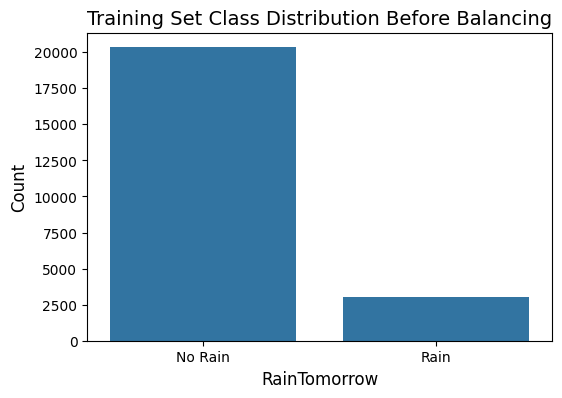

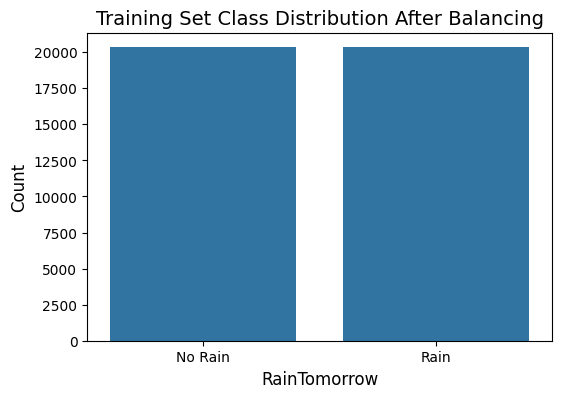

In [ ]:
# Class Balancing

from sklearn.utils import resample
import numpy as np

# Combine X_train and y_train for resampling
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # flatten sequences for resample
train_data = np.hstack((X_train_flat, y_train.reshape(-1,1)))

# Separate majority and minority classes
majority = train_data[train_data[:,-1] == 0]
minority = train_data[train_data[:,-1] == 1]

# Upsample minority class
minority_upsampled = resample(
    minority,
    replace=True,             # sample with replacement
    n_samples=majority.shape[0], # match number of majority class
    random_state=42
)

# Combine back to create balanced training set
balanced_train_data = np.vstack((majority, minority_upsampled))

# Shuffle data
np.random.shuffle(balanced_train_data)

# Split back into X_train and y_train
X_train_balanced = balanced_train_data[:, :-1].reshape(-1, X_train.shape[1], X_train.shape[2])
y_train_balanced = balanced_train_data[:, -1]

print("Balanced training data shapes:")
print("X_train_balanced:", X_train_balanced.shape)
print("y_train_balanced:", y_train_balanced.shape)

y_train_flat = y_train.reshape(-1)
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_flat)
plt.title('Training Set Class Distribution Before Balancing', fontsize=14)
plt.xlabel('RainTomorrow', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0,1], ['No Rain', 'Rain'])
plt.show()

# Visualize training set after balancing
y_train_balanced_flat = y_train_balanced.reshape(-1)
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_balanced_flat)
plt.title('Training Set Class Distribution After Balancing', fontsize=14)
plt.xlabel('RainTomorrow', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0,1], ['No Rain', 'Rain'])
plt.show()

In [ ]:
### Build LSTM model
model_lstm3 = Sequential()
model_lstm3.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm3.add(Dropout(0.2))
model_lstm3.add(Dense(32, activation='relu'))
model_lstm3.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

model_lstm3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model_lstm3.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        46,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,449 (189.25 KB)

 Trainable params: 48,449 (189.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
### Train the model
# from google.colab import drive
# drive.mount('/content/drive')

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Class Balancing
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
class_weight_dict = dict(enumerate(class_weights))

history_lstm3 = model_lstm3.fit(
    X_train_balanced, y_train_balanced,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

# # Save trained LSTM model
# model_lstm.save('rain_prediction_lstm.h5')
# model_lstm.save('/content/drive/MyDrive/rain_prediction_lstm.h5')

Epoch 1/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5636 - loss: 0.6799 - val_accuracy: 0.6325 - val_loss: 0.6399
Epoch 2/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6443 - loss: 0.6311 - val_accuracy: 0.6779 - val_loss: 0.6006
Epoch 3/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6791 - loss: 0.5933 - val_accuracy: 0.7123 - val_loss: 0.5644
Epoch 4/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7209 - loss: 0.5464 - val_accuracy: 0.7456 - val_loss: 0.5183
Epoch 5/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7641 - loss: 0.4847 - val_accuracy: 0.7797 - val_loss: 0.4684
Epoch 6/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7949 - loss: 0.4323 - val_accuracy: 0.7922 - val_loss: 0.4449
Epoch 7/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8272 - loss: 0.3869 - val_accuracy: 0.8365 - val_loss: 0.3853
Epoch 8/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8608 - loss: 0.3312 - val_accuracy: 0.

In [ ]:
### Evaluate model using test data

# if the accuracy is >70%, model is learning
# is the accuracy is >85%, model is perfect

loss, acc = model_lstm3.evaluate(X_test, y_test)
print("Test Accuracy:", acc)

183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7782 - loss: 1.7350
Test Accuracy: 0.7897348403930664


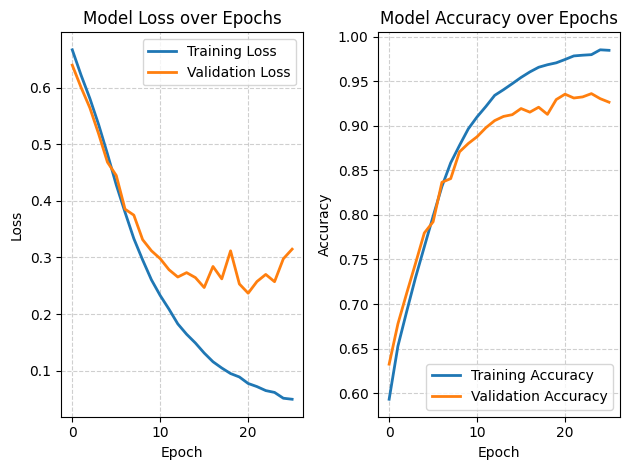

In [ ]:
## Visualize Traning process and history

# --- Plot Training & Validation Loss ---
plt.subplot(1, 2, 1)
plt.plot(history_lstm3.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_lstm3.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss over Epochs', fontsize=12)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# --- Plot Training & Validation Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(history_lstm3.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history_lstm3.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy over Epochs', fontsize=12)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

y_pred_prob = model_lstm3.predict(X_test)          # predicted probabilities
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)  # convert to 0/1 labels
y_true = y_test.reshape(-1)                         # flatten if needed

# Calculate metrics
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)

print("🔹 Test Set Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

# Classification Report
print("\n🔹 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['No Rain', 'Rain']))

183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
🔹 Test Set Metrics:
Accuracy : 0.7897
Precision: 0.1958
Recall   : 0.1925
F1-score : 0.1941

🔹 Classification Report:
              precision    recall  f1-score   support

     No Rain       0.88      0.88      0.88      5076
        Rain       0.20      0.19      0.19       769

    accuracy                           0.79      5845
   macro avg       0.54      0.54      0.54      5845
weighted avg       0.79      0.79      0.79      5845

